# fig1F

/home/fengyu/miniconda3/envs/st/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


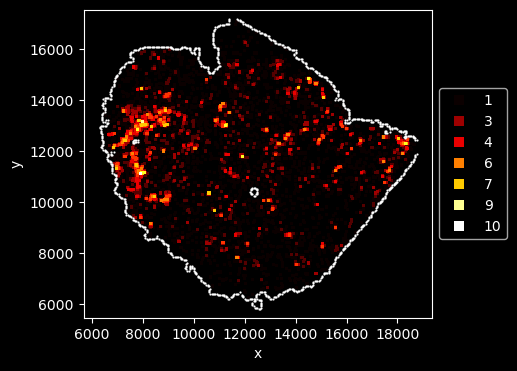

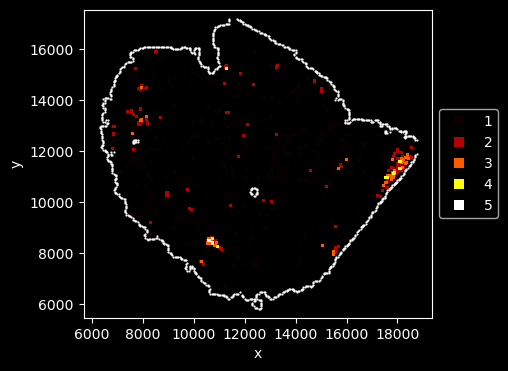

In [1]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load AnnData and prepare data ---
adata11 = sc.read_h5ad('/data3/zhangyang/Method_Final_analysis/D06053D2/test_analysis_celltype/D06053D2.h5ad')
df = adata11.obs.copy()
tissue_outline = pd.DataFrame(adata11.uns['tissue_outline'], columns=['x', 'y'])

# --- Bin coordinates into 50-pixel grids (for both plots) ---
df['x'] = df['x'] // 50 * 50
df['y'] = df['y'] // 50 * 50

# ========================== B cell clone overview ==========================
# Count unique B cell (IGHcdr3aa) clones per grid bin
result_bcell = (
    df.groupby(['x', 'y'])['IGHcdr3aa']
      .nunique()
      .reset_index(name='counts')
).sort_values('counts')

plt.style.use('dark_background')
plt.figure(figsize=(4.5, 4))
plt.grid(False)
sns.scatterplot(
    data=result_bcell[result_bcell['counts'] != 0],
    x='x', y='y', hue='counts',
    s=5, edgecolor=None, marker='s', linewidth=0,
    palette='hot'
)
sns.scatterplot(
    data=tissue_outline, x='x', y='y',
    color='white', s=2, edgecolor=None
)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), markerscale=3)
plt.axis('equal')
plt.savefig('./fig1F_IGH_overview.png', dpi=2500, bbox_inches='tight')
plt.show()

# ========================== T cell clone overview ==========================
# Count unique T cell (TRBcdr3aa) clones per grid bin
result_tcell = (
    df.groupby(['x', 'y'])['TRBcdr3aa']
      .nunique()
      .reset_index(name='counts')
).sort_values('counts')

plt.style.use('dark_background')
plt.figure(figsize=(4.5, 4))
plt.grid(False)
sns.scatterplot(
    data=result_tcell[result_tcell['counts'] != 0],
    x='x', y='y', hue='counts',
    s=5, edgecolor=None, marker='s', linewidth=0,
    palette='hot'
)
sns.scatterplot(
    data=tissue_outline, x='x', y='y',
    color='white', s=2, edgecolor=None
)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), markerscale=3)
plt.axis('equal')
plt.savefig('./fig1F_TRB_overview.png', dpi=2500, bbox_inches='tight')
plt.show()

# fig1H

/home/fengyu/miniconda3/envs/st/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Missing values in 'x': False
Missing values in 'y': False
Number of edge coordinates: 3751
Tissue outline array shape: (3751, 2)


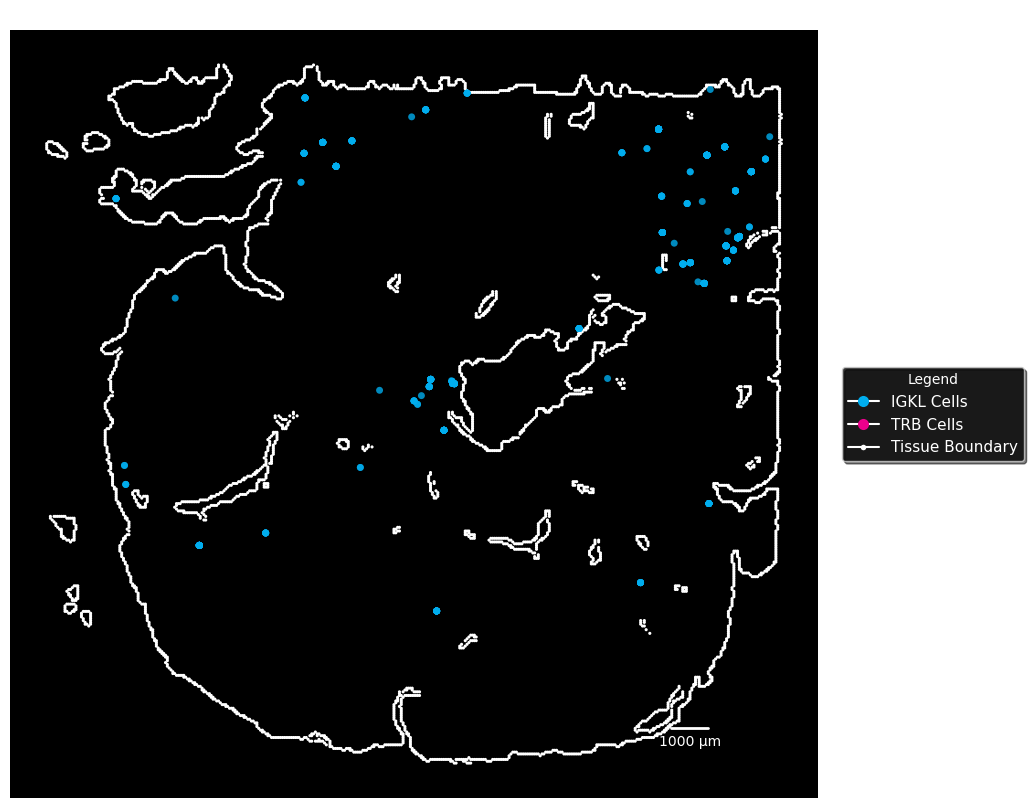

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2 as cv
from matplotlib.lines import Line2D

# ======= 1. Data read-in =======
meta = pd.read_csv(
    '/data3/huangmengye/Stereo-seq-FFPE/Y40056JD/meta-mixcr/03.raw_meta/Y40056JD.matched.fq.gz.meta.gz',
    sep=','
)
adata = sc.read_h5ad('/data3/huangmengye/FFPE-new/Y40056JD.tissue_bin20.h5ad')

# ======= 2. Coordinate & cellID preprocessing =======
meta['bin20_x'] = (meta['x'] // 20) * 20
meta['bin20_y'] = (meta['y'] // 20) * 20
meta['cellID'] = meta['bin20_x'].astype(str) + '_' + meta['bin20_y'].astype(str)
adata.obs['cellID'] = adata.obs['x'].astype(str) + '_' + adata.obs['y'].astype(str)
adata.obs.index = adata.obs.index.astype(str)

# ======= 3. TCR/BCR presence calling =======
for gene in ['TRAC', 'TRBC1', 'TRBC2']:
    adata.obs[f'{gene}_value'] = adata[:, gene].to_df()
adata.obs['TRAC_judge'] = np.where(adata.obs['TRAC_value'] > 0, 'yes', 'no')
adata.obs['TRBC_value'] = adata.obs['TRBC1_value'] + adata.obs['TRBC2_value']
adata.obs['TRBC_judge'] = np.where(adata.obs['TRBC_value'] > 0, 'yes', 'no')

TRA_cellid = adata.obs[adata.obs['TRAC_judge'] == 'yes']['cellID'].tolist()
TRB_cellid = adata.obs[adata.obs['TRBC_judge'] == 'yes']['cellID'].tolist()

for gene in ['IGHG1','IGHG2','IGHG3','IGHG4','IGHA1','IGHA2','IGHM','IGHD','IGHE']:
    adata.obs[f'{gene}_value'] = adata[:, gene].to_df()
adata.obs['IGH_value'] = (
    adata.obs['IGHG1_value'] + adata.obs['IGHG2_value'] + adata.obs['IGHG3_value'] + adata.obs['IGHG4_value'] +
    adata.obs['IGHA1_value'] + adata.obs['IGHA2_value'] + adata.obs['IGHM_value'] +
    adata.obs['IGHD_value'] + adata.obs['IGHE_value']
)
adata.obs['IGH_judge'] = np.where(adata.obs['IGH_value'] > 0, 'yes', 'no')

adata.obs['IGKC_value'] = adata[:, 'IGKC'].to_df()
adata.obs['IGLC2_value'] = adata[:, 'IGLC2'].to_df()
adata.obs['IGLC3_value'] = adata[:, 'IGLC3'].to_df()
adata.obs['IGLC6_value'] = adata[:, 'IGLC6'].to_df()
adata.obs['IGKL_value'] = (
    adata.obs['IGKC_value'] + adata.obs['IGLC2_value'] +
    adata.obs['IGLC3_value'] + adata.obs['IGLC6_value']
)
adata.obs['IGKL_judge'] = np.where(adata.obs['IGKL_value'] > 0, 'yes', 'no')

IGH_cellid = adata.obs[adata.obs['IGH_judge'] == 'yes']['cellID'].tolist()
IGKL_cellid = adata.obs[adata.obs['IGKL_judge'] == 'yes']['cellID'].tolist()

# ========== 4. Tissue outline calculation (NEW: your latest way) ==========
adata.obs['x'] = adata.obs['x'].astype(int)
adata.obs['y'] = adata.obs['y'].astype(int)

# 1. Check for NAs
print(f"Missing values in 'x': {adata.obs['x'].isnull().any()}")
print(f"Missing values in 'y': {adata.obs['y'].isnull().any()}")

# 2. Downscale for visualization
adata.obs['X'] = adata.obs['x'] // 50
adata.obs['Y'] = adata.obs['y'] // 50
df5 = adata.obs[['X', 'Y']]

# 3. Create mask image
max_x = int(df5['X'].max())
max_y = int(df5['Y'].max())
image_size = (max_y + 1, max_x + 1)  # (height, width)
image = np.zeros(image_size, dtype=np.uint8)
for _, row in df5.iterrows():
    x, y = int(row['X']), int(row['Y'])
    image[y, x] = 255

# 4. Canny Edge Detection
edges = cv.Canny(image, 50, 150)
edge_coordinates = np.column_stack(np.where(edges > 0))
print(f"Number of edge coordinates: {len(edge_coordinates)}")

df6 = pd.DataFrame(edge_coordinates, columns=['Y', 'X'])
df6['Y'] = df6['Y'] * 50
df6['X'] = df6['X'] * 50
tissue_outline = df6[['X', 'Y']].values
adata.uns['tissue_outline'] = tissue_outline
print("Tissue outline array shape:", tissue_outline.shape)

# ========== 5. Extract IGKL and TRB spatial records ==========
IGKL_meta = meta.loc[meta['cellID'].isin(IGKL_cellid) & meta['topChains'].isin(['IGK', 'IGL'])].copy()
TRB_meta = meta.loc[meta['cellID'].isin(TRB_cellid) & (meta['topChains'] == 'TRB')].copy()

# ========== 6. Plot ===============
plt.figure(figsize=(12, 10))
sns.set_theme(rc={'axes.facecolor': 'black', 'figure.facecolor': 'black'})
ax = plt.gca()
title = 'IGKL & TRB Distribution'
igkl_color = "#00aeef"
trb_color = "#ed008c"

# Plot tissue outline
if tissue_outline is not None and len(tissue_outline) > 0:
    tissue_outline_df = pd.DataFrame(tissue_outline, columns=['x', 'y'])
    ax.scatter(
        x=tissue_outline_df['x'],
        y=tissue_outline_df['y'],
        s=5,
        c='white',
        edgecolors='none',
        alpha=1.0,
        label='Tissue Boundary'
    )
    x_min, x_max = tissue_outline_df['x'].min(), tissue_outline_df['x'].max()
    y_min, y_max = tissue_outline_df['y'].min(), tissue_outline_df['y'].max()
    x_margin, y_margin = (x_max - x_min) * 0.05, (y_max - y_min) * 0.05
    ax.set_xlim(x_min - x_margin, x_max + x_margin)
    ax.set_ylim(y_min - y_margin, y_max + y_margin)

# IGKL cells
if not IGKL_meta.empty and 'x' in IGKL_meta and 'y' in IGKL_meta:
    ax.scatter(
        x=IGKL_meta['x'],
        y=IGKL_meta['y'],
        s=25,
        c=igkl_color,
        edgecolors='none',
        alpha=0.8,
        label='IGKL Cells'
    )

# TRB cells
if not TRB_meta.empty and 'x' in TRB_meta and 'y' in TRB_meta:
    ax.scatter(
        x=TRB_meta['x'],
        y=TRB_meta['y'],
        s=25,
        c=trb_color,
        edgecolors='none',
        alpha=0.8,
        label='TRB Cells'
    )

# Axis and legend
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticklabels([])
ax.set_yticklabels([])
for spine in ax.spines.values():
    spine.set_visible(False)
ax.set_title(title, fontsize=12, color='white')
ax.tick_params(axis='both', colors='white')
ax.grid(False)
ax.set_aspect('equal')
plt.subplots_adjust(right=0.85)

legend_handles = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor=igkl_color, 
           markersize=8, markeredgewidth=0, label='IGKL Cells'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor=trb_color, 
           markersize=8, markeredgewidth=0, label='TRB Cells'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='white', 
           markersize=4, markeredgewidth=0, label='Tissue Boundary')
]
legend = ax.legend(handles=legend_handles,
                   loc='center left', bbox_to_anchor=(1.02, 0.5),
                   frameon=True, fancybox=True, shadow=True, framealpha=0.8,
                   title='Legend', title_fontsize=10)
plt.setp(legend.get_texts(), color='white')
plt.setp(legend.get_title(), color='white')

# Optional: Scale bar
try:
    scalebar_length = 1000
    scalebar_x = x_max - scalebar_length - (x_max - x_min) * 0.10
    scalebar_y = y_min + (y_max - y_min) * 0.05
    ax.plot([scalebar_x, scalebar_x + scalebar_length],
            [scalebar_y, scalebar_y], color='white', linewidth=2)
    ax.text(scalebar_x + scalebar_length / 2,
            scalebar_y - (y_max - y_min) * 0.01,
            '1000 µm', color='white', ha='center', va='top', fontsize=10)
except Exception as e:
    print(f"Error drawing scale bar: {e}")

plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

In [8]:
import scanpy as sc
import pandas as pd
import numpy as np

# -----------------------
# 1. Load meta and AnnData
# -----------------------
adata = sc.read_h5ad('/data3/huangmengye/FFPE-new/Y40056JD.tissue_bin20.h5ad')
meta = pd.read_csv(
    '/data3/huangmengye/FFPE-new/A-FFPE-20260103/FFPE-NEW-JD/meta-XCR/03.raw_meta/sample_Y40056JD_read_1_6.fastq.gz.meta.gz',
    sep=',')
# -----------------------
# 2. Calculate binned cellID and add to meta and adata
# -----------------------
meta['bin20_x'] = meta['x'] // 20 * 20
meta['bin20_y'] = meta['y'] // 20 * 20
meta['cellID'] = meta['bin20_x'].astype(str) + '_' + meta['bin20_y'].astype(str)
adata.obs['cellID'] = adata.obs['x'].astype(str) + '_' + adata.obs['y'].astype(str)

# -----------------------
# 3. Ensure index is string type
# -----------------------
adata.obs.index = adata.obs.index.astype(str)
adata.obs['TRAC_value'] = adata[:, 'TRAC'].to_df()
adata.obs['TRAC_judge'] = 'yes'
adata.obs.loc[adata.obs['TRAC_value'] == 0, 'TRAC_judge'] = 'no'

adata.obs['TRBC1_value'] = adata[:, 'TRBC1'].to_df()
adata.obs['TRBC2_value'] = adata[:, 'TRBC2'].to_df()
adata.obs['TRBC_value'] = adata.obs['TRBC1_value'] + adata.obs['TRBC2_value']
adata.obs['TRBC_judge'] = 'yes'
adata.obs.loc[adata.obs['TRBC_value'] == 0, 'TRBC_judge'] = 'no'

# -----------------------
# 6. Extract TRAC/TRBC positive cellIDs
# -----------------------
TRA_cellid = adata.obs[adata.obs['TRAC_judge'] == 'yes']['cellID'].astype(str).tolist()
TRB_cellid = adata.obs[adata.obs['TRBC_judge'] == 'yes']['cellID'].astype(str).tolist()

# -----------------------
# 7. BCR heavy chain positivity judgement
# -----------------------
adata.obs['IGHG1_value'] = adata[:, 'IGHG1'].to_df()
adata.obs['IGHG2_value'] = adata[:, 'IGHG2'].to_df()
adata.obs['IGHG3_value'] = adata[:, 'IGHG3'].to_df()
adata.obs['IGHG4_value'] = adata[:, 'IGHG4'].to_df()
adata.obs['IGHA1_value'] = adata[:, 'IGHA1'].to_df()
adata.obs['IGHA2_value'] = adata[:, 'IGHA2'].to_df()
adata.obs['IGHM_value'] = adata[:, 'IGHM'].to_df()
adata.obs['IGHD_value'] = adata[:, 'IGHD'].to_df()
adata.obs['IGHE_value'] = adata[:, 'IGHE'].to_df()
adata.obs['IGH_value'] = (
    adata.obs['IGHG1_value'] +
    adata.obs['IGHG2_value'] +
    adata.obs['IGHG3_value'] +
    adata.obs['IGHG4_value'] +
    adata.obs['IGHA1_value'] +
    adata.obs['IGHA2_value'] +
    adata.obs['IGHM_value'] +
    adata.obs['IGHD_value'] +
    adata.obs['IGHE_value']
)
adata.obs['IGH_judge'] = 'yes'
adata.obs.loc[adata.obs['IGH_value'] == 0, 'IGH_judge'] = 'no'

# -----------------------
# 8. BCR light chain positivity judgement
# -----------------------
adata.obs['IGKC_value'] = adata[:, 'IGKC'].to_df()
# adata.obs['IGLC1_value'] = adata[:, 'IGLC1'].to_df()  # Uncomment if you want to include IGLC1
adata.obs['IGLC2_value'] = adata[:, 'IGLC2'].to_df()
adata.obs['IGLC3_value'] = adata[:, 'IGLC3'].to_df()
adata.obs['IGLC6_value'] = adata[:, 'IGLC6'].to_df()
adata.obs['IGKL_value'] = (
    adata.obs['IGKC_value'] +
    adata.obs['IGLC2_value'] +
    adata.obs['IGLC3_value'] +
    adata.obs['IGLC6_value']
)
adata.obs['IGKL_judge'] = 'yes'
adata.obs.loc[adata.obs['IGKL_value'] == 0, 'IGKL_judge'] = 'no'

# -----------------------
# 9. Extract positive cellIDs for BCR
# -----------------------
IGH_cellid = adata.obs[adata.obs['IGH_judge'] == 'yes']['cellID'].astype(str).tolist()
IGKL_cellid = adata.obs[adata.obs['IGKL_judge'] == 'yes']['cellID'].astype(str).tolist()

In [9]:
import pandas as pd
import numpy as np

# ============================== #
#      Parameter configuration   #
# ============================== #
TRA_MIN_READS = 1       # Min reads/UMI for TRA
TRB_MIN_READS = 1       # Min reads/UMI for TRB
TCR_FILTER_READS = 5    # Min reads for meta_tcr second filtering
FINAL_COL_SUFFIX = "15" # Final result columns' suffix in obs
WORKING_SUFFIX = "XCR"  # Temp obs column suffix (to avoid overwriting)

# ============================== #
#         General filter         #
# ============================== #
TRA = meta[meta['topChains'] == 'TRA']
TRA = TRA[TRA['cellID'].isin(TRA_cellid)]

TRB = meta[meta['topChains'] == 'TRB']
TRB = TRB[TRB['cellID'].isin(TRB_cellid)]

TRA['cid_umi'] = TRA['cid'] + '_' + TRA['umi']
TRB['cid_umi'] = TRB['cid'] + '_' + TRB['umi']

def filter_by_readcount_and_function(df, min_reads=4, readid_col='readId'):
    """Keep rows where each cid_umi has >= min_reads unique readIDs and is Functional."""
    counts = df.groupby('cid_umi')[readid_col].nunique()
    valid = counts[counts >= min_reads].index
    df = df[df['cid_umi'].isin(valid)]
    df = df[df['functional'] == 'Functional']
    return df

# -- 1. Filter TRA and TRB chains separately
filtered_tra = filter_by_readcount_and_function(TRA, min_reads=TRA_MIN_READS)
filtered_trb = filter_by_readcount_and_function(TRB, min_reads=TRB_MIN_READS)
meta_filtered = pd.concat([filtered_tra, filtered_trb], ignore_index=True)
TCR = pd.concat([filtered_tra, filtered_trb], ignore_index=True)

# -- 2. Best cdr3aa voting function
def extract_best_cdr3aa(
    df,
    chain_letter="A",     # "A" for TRA, "B" for TRB
    cdr3_col="junction_aa",
    umi_col="cid_umi",
    cellid_col="cellID"
):
    # UMI-level voting
    unique_counts = df.groupby(umi_col)[cdr3_col].nunique().reset_index()
    multiple_cdr3aa = unique_counts[unique_counts[cdr3_col] > 1]
    unique_cdr3aa = unique_counts[unique_counts[cdr3_col] == 1]
    retrievable_umi = multiple_cdr3aa[multiple_cdr3aa[cdr3_col] <= 10][umi_col]
    retrievable = df[df[umi_col].isin(retrievable_umi)]
    cdr3aa_counts = retrievable.groupby([umi_col, cdr3_col]).size().reset_index(name="count")
    voted_cdr3aa = cdr3aa_counts.loc[cdr3aa_counts.groupby(umi_col)["count"].idxmax()]
    df1 = pd.concat([
        df[df[umi_col].isin(unique_cdr3aa[umi_col].unique())],
        df[df[umi_col].isin(voted_cdr3aa[umi_col].unique())]
    ], ignore_index=True)
    # cellID-level voting
    unique_counts = df1.groupby(cellid_col)[cdr3_col].nunique().reset_index()
    multiple_cdr3aa = unique_counts[unique_counts[cdr3_col] > 1]
    unique_cdr3aa = unique_counts[unique_counts[cdr3_col] == 1]
    retrievable_id = multiple_cdr3aa[multiple_cdr3aa[cdr3_col] <= 10][cellid_col]
    retrievable = df1[df1[cellid_col].isin(retrievable_id)]
    cdr3aa_counts = retrievable.groupby([cellid_col, cdr3_col]).size().reset_index(name="count")
    voted_cdr3aa = cdr3aa_counts.loc[cdr3aa_counts.groupby(cellid_col)["count"].idxmax()]
    result = df1[df1[cellid_col].isin(unique_cdr3aa[cellid_col])][[cellid_col, cdr3_col]].drop_duplicates(subset=[cellid_col, cdr3_col])
    result = pd.concat([result, voted_cdr3aa[[cellid_col, cdr3_col]]], ignore_index=True)
    out_col = f"TR{chain_letter}cdr3aa"
    result.rename(columns={cdr3_col: out_col, cellid_col: "cellID"}, inplace=True)
    result["cellID"] = result["cellID"].astype(str)
    return result[["cellID", out_col]]

# -- 3. Merge best cdr3aa result into obs
result_TRA = extract_best_cdr3aa(filtered_tra, chain_letter="A")
adata.obs['cellID'] = adata.obs['cellID'].astype(str)
adata.obs = adata.obs.merge(result_TRA, on="cellID", how="left")
result_TRB = extract_best_cdr3aa(filtered_trb, chain_letter="B")
adata.obs = adata.obs.merge(result_TRB, on="cellID", how="left")

# -- 4. Prepare meta_subset and secondary TCR voting
meta_subset = meta[~meta['cellID'].isin(TRA_cellid) & ~meta['cellID'].isin(TRB_cellid)].copy()
meta_subset['TCRorBCR'] = 'BCR'
meta_subset.loc[meta_subset['topChains'].isin(['TRA','TRB']), 'TCRorBCR'] = 'TCR'
meta_subset['cid_umi'] = meta_subset['cid'] + '_' + meta_subset['umi'].astype(str)
meta_subset['loc'] = meta_subset['x'].astype(str) + '_' + meta_subset['y'].astype(str)

meta_tcr = meta_subset[meta_subset['TCRorBCR'] == 'TCR'].copy()
meta_tcr = filter_by_readcount_and_function(meta_tcr, min_reads=TCR_FILTER_READS)
meta_tcr['cellID'] = meta_tcr['cellID'].astype(str)

# -- TRA (meta_tcr) best cdr3aa voting (XCR)
TRA = meta_tcr[meta_tcr['topChains']=='TRA']
unique_counts = TRA.groupby('cid_umi')['junction_aa'].nunique().reset_index()
multiple_cdr3aa = unique_counts[unique_counts['junction_aa'] > 1]
unique_cdr3aa = unique_counts[unique_counts['junction_aa'] == 1]
retrievable_UMI = multiple_cdr3aa[multiple_cdr3aa['junction_aa']<=10]['cid_umi']
retrievable = TRA[TRA['cid_umi'].isin(retrievable_UMI)]
cdr3aa_counts = retrievable.groupby(['cid_umi', 'junction_aa']).size().reset_index(name='count')
voted_cdr3aa = cdr3aa_counts.loc[cdr3aa_counts.groupby('cid_umi')['count'].idxmax()]
df = pd.concat(
    [TRA[TRA['cid_umi'].isin(unique_cdr3aa['cid_umi'].unique())],
     TRA[TRA['cid_umi'].isin(voted_cdr3aa['cid_umi'].unique())]],
    ignore_index=True)
unique_counts = df.groupby('cellID')['junction_aa'].nunique().reset_index()
multiple_cdr3aa = unique_counts[unique_counts['junction_aa'] > 1]
unique_cdr3aa = unique_counts[unique_counts['junction_aa'] == 1]
retrievable_ID = multiple_cdr3aa[multiple_cdr3aa['junction_aa']<=10]['cellID']
retrievable = df[df['cellID'].isin(retrievable_ID)]
cdr3aa_counts = retrievable.groupby(['cellID', 'junction_aa']).size().reset_index(name='count')
voted_cdr3aa = cdr3aa_counts.loc[cdr3aa_counts.groupby('cellID')['count'].idxmax()]
result = df[df['cellID'].isin(unique_cdr3aa['cellID'])][['cellID','junction_aa']].drop_duplicates(subset=['cellID','junction_aa'])
result = pd.concat([result, voted_cdr3aa[['cellID','junction_aa']]], ignore_index=True)
result.rename(columns={'junction_aa': f'TRAcdr3aa_{WORKING_SUFFIX}'}, inplace=True)
result['cellID'] = result['cellID'].astype(str)
adata.obs = adata.obs.merge(result, on='cellID', how="left")

# -- TRB (meta_tcr) best cdr3aa voting (XCR)
print("2.2 Processing TRB Info ...")
TRB = meta_tcr[meta_tcr['topChains']=='TRB']
unique_counts = TRB.groupby('cid_umi')['junction_aa'].nunique().reset_index()
multiple_cdr3aa = unique_counts[unique_counts['junction_aa'] > 1]
unique_cdr3aa = unique_counts[unique_counts['junction_aa'] == 1]
retrievable_UMI = multiple_cdr3aa[multiple_cdr3aa['junction_aa']<=10]['cid_umi']
retrievable = TRB[TRB['cid_umi'].isin(retrievable_UMI)]
cdr3aa_counts = retrievable.groupby(['cid_umi', 'junction_aa']).size().reset_index(name='count')
voted_cdr3aa = cdr3aa_counts.loc[cdr3aa_counts.groupby('cid_umi')['count'].idxmax()]
df = pd.concat(
    [TRB[TRB['cid_umi'].isin(unique_cdr3aa['cid_umi'].unique())],
     TRB[TRB['cid_umi'].isin(voted_cdr3aa['cid_umi'].unique())]],
    ignore_index=True)
unique_counts = df.groupby('cellID')['junction_aa'].nunique().reset_index()
multiple_cdr3aa = unique_counts[unique_counts['junction_aa'] > 1]
unique_cdr3aa = unique_counts[unique_counts['junction_aa'] == 1]
retrievable_ID = multiple_cdr3aa[multiple_cdr3aa['junction_aa']<=10]['cellID']
retrievable = df[df['cellID'].isin(retrievable_ID)]
cdr3aa_counts = retrievable.groupby(['cellID', 'junction_aa']).size().reset_index(name='count')
voted_cdr3aa = cdr3aa_counts.loc[cdr3aa_counts.groupby('cellID')['count'].idxmax()]
result = df[df['cellID'].isin(unique_cdr3aa['cellID'])][['cellID','junction_aa']].drop_duplicates(subset=['cellID','junction_aa'])
result = pd.concat([result, voted_cdr3aa[['cellID','junction_aa']]], ignore_index=True)
result.rename(columns={'junction_aa': f'TRBcdr3aa_{WORKING_SUFFIX}'}, inplace=True)
result['cellID'] = result['cellID'].astype(str)
adata.obs = adata.obs.merge(result, on='cellID', how='left')

# -- mask and obs filling --
mask = (~adata.obs[f'TRAcdr3aa_{WORKING_SUFFIX}'].isna()) & (~adata.obs[f'TRBcdr3aa_{WORKING_SUFFIX}'].isna())
adata.obs.loc[~mask, [f'TRAcdr3aa_{WORKING_SUFFIX}', f'TRBcdr3aa_{WORKING_SUFFIX}']] = np.nan

if 'TRAcdr3aa' not in adata.obs:
    adata.obs['TRAcdr3aa'] = np.nan
if 'TRBcdr3aa' not in adata.obs:
    adata.obs['TRBcdr3aa'] = np.nan

mask_tra = adata.obs['TRAcdr3aa'].isna()
adata.obs.loc[mask_tra, 'TRAcdr3aa'] = adata.obs.loc[mask_tra, f'TRAcdr3aa_{WORKING_SUFFIX}']
mask_trb = adata.obs['TRBcdr3aa'].isna()
adata.obs.loc[mask_trb, 'TRBcdr3aa'] = adata.obs.loc[mask_trb, f'TRBcdr3aa_{WORKING_SUFFIX}']

# -- Rename and delete working columns --
adata.obs.rename(columns={'TRAcdr3aa': f'TRAcdr3aa_{FINAL_COL_SUFFIX}'}, inplace=True)
adata.obs.rename(columns={'TRBcdr3aa': f'TRBcdr3aa_{FINAL_COL_SUFFIX}'}, inplace=True)
del adata.obs[f'TRAcdr3aa_{WORKING_SUFFIX}']
del adata.obs[f'TRBcdr3aa_{WORKING_SUFFIX}']

print(f"Vote/merging completed. Output obs columns: TRAcdr3aa_{FINAL_COL_SUFFIX}, TRBcdr3aa_{FINAL_COL_SUFFIX}")

/home/fengyu/miniconda3/envs/st/lib/python3.8/site-packages/anndata/_core/anndata.py:788: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)
/home/fengyu/miniconda3/envs/st/lib/python3.8/site-packages/anndata/_core/anndata.py:788: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)
/home/fengyu/miniconda3/envs/st/lib/python3.8/site-packages/anndata/_core/anndata.py:788: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)


2.2 Processing TRB Info ...


/home/fengyu/miniconda3/envs/st/lib/python3.8/site-packages/anndata/_core/anndata.py:788: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)


Vote/merging completed. Output obs columns: TRAcdr3aa_15, TRBcdr3aa_15


In [10]:
import pandas as pd
import numpy as np

# ============================== #
#      Parameter configuration   #
# ============================== #
IGH_MIN_READS = 2         # minimum reads required for IGH chain
IGKL_MIN_READS = 2        # minimum reads required for IGK/IGL chain
BCR_XCR_FILTER_READS = 10 # secondary filter read count for meta_bcr
FINAL_COL_SUFFIX = "210"  # Suffix for final output columns in obs
WORKING_SUFFIX = "XCR"    # Suffix for temporary working columns

# ============================== #
#         General filter         #
# ============================== #
def filter_by_readcount_and_function(df, min_reads=4, readid_col='readId'):
    """Retain rows where each cid_umi has >= min_reads unique readIds and is Functional."""
    counts = df.groupby('cid_umi')[readid_col].nunique()
    valid = counts[counts >= min_reads].index
    df = df[df['cid_umi'].isin(valid)]
    df = df[df['functional'] == 'Functional']
    return df

# ================================ #
#        BCR chain pre-filtering   #
# ================================ #
IGH = meta[meta['topChains'] == 'IGH']
IGH = IGH[IGH['cellID'].isin(IGH_cellid)]
IGH['cid_umi'] = IGH['cid'] + '_' + IGH['umi']

IGKL = meta[meta['topChains'].isin(['IGK', 'IGL'])]
IGKL = IGKL[IGKL['cellID'].isin(IGKL_cellid)]
IGKL['cid_umi'] = IGKL['cid'] + '_' + IGKL['umi']

filtered_igh = filter_by_readcount_and_function(IGH, min_reads=IGH_MIN_READS)
filtered_igkl = filter_by_readcount_and_function(IGKL, min_reads=IGKL_MIN_READS)
BCR = pd.concat([filtered_igh, filtered_igkl], ignore_index=True)

# ================================ #
#        IGH best CDR3 voting      #
# ================================ #
def extract_best_igh(df):
    unique_counts = df.groupby('cid_umi')['junction_aa'].nunique().reset_index()
    multi = unique_counts[unique_counts['junction_aa'] > 1]
    uniq = unique_counts[unique_counts['junction_aa'] == 1]
    retrievable_umi = multi[multi['junction_aa'] <= 10]['cid_umi']
    retrievable = df[df['cid_umi'].isin(retrievable_umi)]
    cdr3_counts = retrievable.groupby(['cid_umi', 'junction_aa']).size().reset_index(name='count')
    voted_cdr3aa = cdr3_counts.loc[cdr3_counts.groupby('cid_umi')['count'].idxmax()]
    df1 = pd.concat([
        df[df['cid_umi'].isin(uniq['cid_umi'].unique())],
        df[df['cid_umi'].isin(voted_cdr3aa['cid_umi'].unique())]
    ], ignore_index=True)
    unique_counts = df1.groupby('cellID')['junction_aa'].nunique().reset_index()
    multi = unique_counts[unique_counts['junction_aa'] > 1]
    uniq = unique_counts[unique_counts['junction_aa'] == 1]
    retrievable_id = multi[multi['junction_aa'] <= 10]['cellID']
    retrievable = df1[df1['cellID'].isin(retrievable_id)]
    cdr3_counts = retrievable.groupby(['cellID', 'junction_aa']).size().reset_index(name='count')
    voted_cdr3aa = cdr3_counts.loc[cdr3_counts.groupby('cellID')['count'].idxmax()]
    result = df1[df1['cellID'].isin(uniq['cellID'])][['cellID','junction_aa']].drop_duplicates(subset=['cellID','junction_aa'])
    result = pd.concat([result, voted_cdr3aa[['cellID','junction_aa']]], ignore_index=True)
    result.rename(columns={'junction_aa': 'IGHcdr3aa'}, inplace=True)
    result['cellID'] = result['cellID'].astype(str)
    return result

result_igh = extract_best_igh(BCR[BCR['topChains'] == 'IGH'])

# ================================ #
#        IGKL best CDR3 voting     #
# ================================ #
def extract_best_igkl(df):
    unique_counts = df.groupby('cid_umi')['junction_aa'].nunique().reset_index()
    multi = unique_counts[unique_counts['junction_aa'] > 1]
    uniq = unique_counts[unique_counts['junction_aa'] == 1]
    retrievable_umi = multi[multi['junction_aa'] <= 10]['cid_umi']
    retrievable = df[df['cid_umi'].isin(retrievable_umi)]
    cdr3_counts = retrievable.groupby(['cid_umi', 'junction_aa']).size().reset_index(name='count')
    voted_cdr3aa = cdr3_counts.loc[cdr3_counts.groupby('cid_umi')['count'].idxmax()]
    df1 = pd.concat([
        df[df['cid_umi'].isin(uniq['cid_umi'].unique())],
        df[df['cid_umi'].isin(voted_cdr3aa['cid_umi'].unique())]
    ], ignore_index=True)
    unique_counts = df1.groupby('cellID')['topChains'].nunique().reset_index()
    multi = unique_counts[unique_counts['topChains'] > 1]
    uniq = unique_counts[unique_counts['topChains'] == 1]
    retrievable = df1[df1['cellID'].isin(multi['cellID'])]
    cdr3_counts = retrievable.groupby(['cellID', 'topChains']).size().reset_index(name='count')
    voted_chain = cdr3_counts.loc[cdr3_counts.groupby('cellID')['count'].idxmax()]
    voted_chain['cellID_iso'] = voted_chain['cellID'].map(str) + voted_chain['topChains']
    df1['cellID_iso'] = df1['cellID'].map(str) + df1['topChains']
    df2 = pd.concat([
        df1[df1['cellID_iso'].isin(voted_chain['cellID_iso'])],
        df1[df1['cellID'].isin(uniq['cellID'])]
    ], ignore_index=True)
    unique_counts = df2.groupby('cellID')['junction_aa'].nunique().reset_index()
    multi = unique_counts[unique_counts['junction_aa'] > 1]
    uniq = unique_counts[unique_counts['junction_aa'] == 1]
    retrievable_id = multi[multi['junction_aa'] <= 10]['cellID']
    retrievable = df2[df2['cellID'].isin(retrievable_id)]
    cdr3_counts = retrievable.groupby(['cellID', 'junction_aa']).size().reset_index(name='count')
    voted_cdr3aa = cdr3_counts.loc[cdr3_counts.groupby('cellID')['count'].idxmax()]
    result = df2[df2['cellID'].isin(uniq['cellID'])][['cellID','junction_aa']].drop_duplicates(subset=['cellID','junction_aa'])
    result = pd.concat([result, voted_cdr3aa[['cellID','junction_aa']]], ignore_index=True)
    topChains_map = df2[['cellID','topChains']].drop_duplicates(subset=['cellID','topChains']).set_index('cellID')['topChains']
    result['topChains'] = result['cellID'].map(topChains_map)
    result.rename(columns={'junction_aa': 'IGK/Lcdr3aa', 'topChains': 'IGKorIGL'}, inplace=True)
    result['cellID'] = result['cellID'].astype(str)
    return result

result_igkl = extract_best_igkl(BCR[BCR['topChains'].isin(['IGK', 'IGL'])])

# ================================ #
#     Merge result into obs        #
# ================================ #
adata.obs['cellID'] = adata.obs['cellID'].astype(str)
adata.obs = adata.obs.merge(result_igh, on='cellID', how='left')
adata.obs = adata.obs.merge(result_igkl, on='cellID', how='left')

# ================================ #
#      BCR-XCR reuse strategy      #
# ================================ #
meta_subset = meta[~meta['cellID'].isin(IGH_cellid) & ~meta['cellID'].isin(IGKL_cellid)].copy()
meta_subset['TCRorBCR'] = 'BCR'
meta_subset.loc[meta_subset['topChains'].isin(['TRA','TRB']), 'TCRorBCR'] = 'TCR'
meta_subset['cid_umi'] = meta_subset['cid'] + '_' + meta_subset['umi']
meta_subset['loc'] = meta_subset['x'].astype(str) + '_' + meta_subset['y'].astype(str)

meta_bcr = meta_subset[meta_subset['TCRorBCR'] == 'BCR'].copy()
meta_bcr = filter_by_readcount_and_function(meta_bcr, min_reads=BCR_XCR_FILTER_READS)
meta_bcr['cellID'] = meta_bcr['cellID'].astype(str)

# IGH-XCR
result_igh_xcr = extract_best_igh(meta_bcr[meta_bcr['topChains'] == 'IGH'])
result_igh_xcr.rename(columns={'IGHcdr3aa': f'IGHcdr3aa_{WORKING_SUFFIX}'}, inplace=True)
adata.obs = adata.obs.merge(result_igh_xcr, on='cellID', how='left')

# IGKL-XCR
result_igkl_xcr = extract_best_igkl(meta_bcr[meta_bcr['topChains'].isin(['IGK','IGL'])])
result_igkl_xcr.rename(columns={'IGK/Lcdr3aa': f'IGK/Lcdr3aa_{WORKING_SUFFIX}', 'IGKorIGL': f'IGKorIGL_{WORKING_SUFFIX}'}, inplace=True)
adata.obs = adata.obs.merge(result_igkl_xcr, on='cellID', how='left')

# ================================ #
#        Mask and result filling   #
# ================================ #
mask = (
    (~adata.obs[f'IGHcdr3aa_{WORKING_SUFFIX}'].isna()) &
    (~adata.obs[f'IGK/Lcdr3aa_{WORKING_SUFFIX}'].isna()) &
    (~adata.obs[f'IGKorIGL_{WORKING_SUFFIX}'].isna())
)
adata.obs.loc[~mask, [f'IGHcdr3aa_{WORKING_SUFFIX}', f'IGK/Lcdr3aa_{WORKING_SUFFIX}', f'IGKorIGL_{WORKING_SUFFIX}']] = np.nan

if 'IGHcdr3aa' not in adata.obs:
    adata.obs['IGHcdr3aa'] = np.nan
if 'IGK/Lcdr3aa' not in adata.obs:
    adata.obs['IGK/Lcdr3aa'] = np.nan
if 'IGKorIGL' not in adata.obs:
    adata.obs['IGKorIGL'] = np.nan

mask_igh = adata.obs['IGHcdr3aa'].isna()
adata.obs.loc[mask_igh, 'IGHcdr3aa'] = adata.obs.loc[mask_igh, f'IGHcdr3aa_{WORKING_SUFFIX}']
mask_igkl = adata.obs['IGK/Lcdr3aa'].isna()
adata.obs.loc[mask_igkl, 'IGK/Lcdr3aa'] = adata.obs.loc[mask_igkl, f'IGK/Lcdr3aa_{WORKING_SUFFIX}']
mask_igkorigl = adata.obs['IGKorIGL'].isna()
adata.obs.loc[mask_igkorigl, 'IGKorIGL'] = adata.obs.loc[mask_igkorigl, f'IGKorIGL_{WORKING_SUFFIX}']

# Final renaming of columns
adata.obs.rename(columns={'IGHcdr3aa': f'IGHcdr3aa_{FINAL_COL_SUFFIX}'}, inplace=True)
adata.obs.rename(columns={'IGK/Lcdr3aa': f'IGK/Lcdr3aa_{FINAL_COL_SUFFIX}'}, inplace=True)
adata.obs.rename(columns={'IGKorIGL': f'IGKorIGL_{FINAL_COL_SUFFIX}'}, inplace=True)

del adata.obs[f'IGHcdr3aa_{WORKING_SUFFIX}']
del adata.obs[f'IGK/Lcdr3aa_{WORKING_SUFFIX}']
del adata.obs[f'IGKorIGL_{WORKING_SUFFIX}']

print(f"Process completed, output columns: IGHcdr3aa_{FINAL_COL_SUFFIX}, IGK/Lcdr3aa_{FINAL_COL_SUFFIX}, IGKorIGL_{FINAL_COL_SUFFIX}")

/home/fengyu/miniconda3/envs/st/lib/python3.8/site-packages/anndata/_core/anndata.py:788: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)
/home/fengyu/miniconda3/envs/st/lib/python3.8/site-packages/anndata/_core/anndata.py:788: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)
/home/fengyu/miniconda3/envs/st/lib/python3.8/site-packages/anndata/_core/anndata.py:788: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)


Process completed, output columns: IGHcdr3aa_210, IGK/Lcdr3aa_210, IGKorIGL_210


/home/fengyu/miniconda3/envs/st/lib/python3.8/site-packages/anndata/_core/anndata.py:788: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)


In [11]:
# Combine IGKL and TRB meta information from filtered and re-annotated sources
IGKL_meta = pd.concat([filtered_igkl, meta_bcr[meta_bcr['topChains'] == 'IGKL']], ignore_index=True)
TRB_meta = pd.concat([filtered_trb, meta_tcr[meta_tcr['topChains'] == 'TRBC']], ignore_index=True)

# Ensure the main AnnData index is of type string for compatibility and downstream operations
adata.obs.index = adata.obs.index.astype(str)

# Calculate per-condition gene scores for BCR and TCR markers, store as new columns in obs
sc.tl.score_genes(
    adata, 
    gene_list=['IGKC', 'IGLC2', 'IGLC3', 'IGLC4', 'IGLC6', 'IGLC7'],
    score_name='BCR'
)
sc.tl.score_genes(
    adata, 
    gene_list=['TRBC1', 'TRBC2'],
    score_name='TCR'
)

In [13]:
import cv2 as cv
# ============================================================
# Convert coordinates to integer and bin them
# ============================================================
adata.obs['x'] = adata.obs['x'].astype(int)
adata.obs['y'] = adata.obs['y'].astype(int)
adata.obs['X'] = adata.obs['x'] // 50
adata.obs['Y'] = adata.obs['y'] // 50
df5 = adata.obs[['X', 'Y']]

# ============================================================
# Create a blank binary image and draw coordinates
# ============================================================
max_x = int(df5['X'].max())
max_y = int(df5['Y'].max())
image_size = (max_y + 1, max_x + 1)  # (rows, cols)
image = np.zeros(image_size, dtype=np.uint8)

for _, row in df5.iterrows():
    x, y = row['X'], row['Y']
    image[y, x] = 255

# ============================================================
# Morphological closing to fill small holes
# ============================================================
kernel_size = 3
kernel = np.ones((kernel_size, kernel_size), np.uint8)
closed_image = cv.morphologyEx(image, cv.MORPH_CLOSE, kernel)

# ============================================================
# Gaussian blur for edge smoothing
# ============================================================
blur_size = 7
blurred_image = cv.GaussianBlur(closed_image, (blur_size, blur_size), 0)

# ============================================================
# Canny edge detection (adaptive threshold)
# ============================================================
v = np.median(blurred_image)
lower = int(max(0, (1.0 - 0.33) * v))
upper = int(min(255, (1.0 + 0.33) * v))
edges = cv.Canny(blurred_image, lower, upper)

# ============================================================
# Optional: contour filtering - keep only large contours
# ============================================================
contours, _ = cv.findContours(edges, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
edges_clean = np.zeros_like(edges)
min_area = 5  # Minimum contour area, increase if desired
for contour in contours:
    area = cv.contourArea(contour)
    if area > min_area:
        cv.drawContours(edges_clean, [contour], -1, 255, 1)

edges = edges_clean  # Use filtered edge image

# ============================================================
# Extract edge coordinates from the binary edge image
# ============================================================
edge_coordinates = np.column_stack(np.where(edges > 0))
df6 = pd.DataFrame(edge_coordinates, columns=['Y', 'X'])
df6['Y'] = df6['Y'] * 50
df6['X'] = df6['X'] * 50

tissue_outline = df6[['X', 'Y']].values
adata.uns['tissue_outline'] = tissue_outline

print(f"Number of tissue outline points after processing: {len(tissue_outline)}")

Number of tissue outline points after processing: 3217


Thresholds: BCR > 0.25, TCR > 0.3


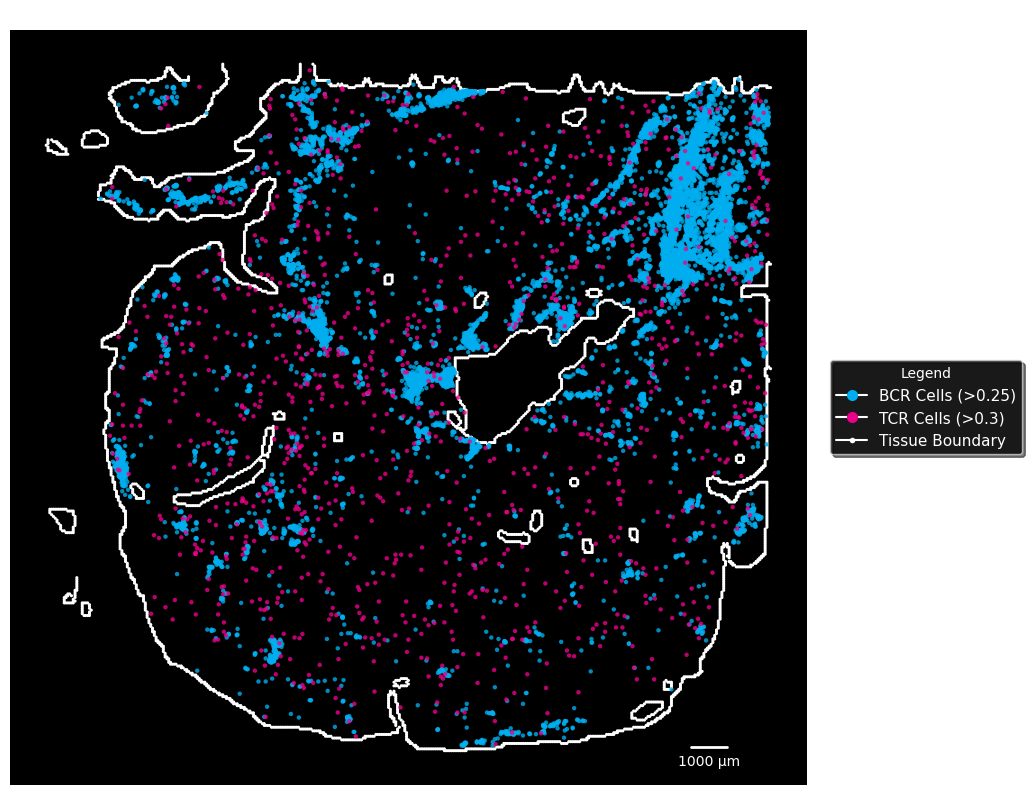

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
from matplotlib.lines import Line2D

# Set BCR and TCR thresholds
BCR_threshold = 0.25
TCR_threshold = 0.3

print(f"Thresholds: BCR > {BCR_threshold}, TCR > {TCR_threshold}")

# Extract cell coordinates and BCR/TCR scores from AnnData (adata)
if hasattr(adata, 'obs') and 'BCR' in adata.obs.columns and 'TCR' in adata.obs.columns:
    if 'spatial' in adata.obsm_keys():
        spatial_coords = adata.obsm['spatial']
        cells_data = pd.DataFrame({
            'x': spatial_coords[:, 0],
            'y': spatial_coords[:, 1],
            'BCR': adata.obs['BCR'].values,
            'TCR': adata.obs['TCR'].values
        })
    elif 'x' in adata.obs.columns and 'y' in adata.obs.columns:
        cells_data = pd.DataFrame({
            'x': adata.obs['x'].values,
            'y': adata.obs['y'].values,
            'BCR': adata.obs['BCR'].values,
            'TCR': adata.obs['TCR'].values
        })
    else:
        cells_data = pd.DataFrame(columns=['x', 'y', 'BCR', 'TCR'])
else:
    print("Error: BCR and/or TCR scores not found in adata.obs")
    cells_data = pd.DataFrame(columns=['x', 'y', 'BCR', 'TCR'])

BCR_positive_cells = cells_data[cells_data['BCR'] > BCR_threshold].copy()
TCR_positive_cells = cells_data[cells_data['TCR'] > TCR_threshold].copy()

# Ensure output directory exists
os.makedirs('/data3/huangmengye/FFPE-new/A-20251208-FFPE-new/filter-jiaoben', exist_ok=True)

# Create the figure with a dark background for clarity
plt.figure(figsize=(12, 10))
sns.set_theme(rc={'axes.facecolor': 'black', 'figure.facecolor': 'black'})
ax = plt.gca()
title = f'BCR & TCR Distribution (BCR>{BCR_threshold}, TCR>{TCR_threshold})'
BCR_color = "#00aeef"
TCR_color = "#ed008c"

# Draw tissue outline points (white) as the background
if 'tissue_outline' in locals() or 'tissue_outline' in globals():
    tissue_outline_df = pd.DataFrame(tissue_outline, columns=['x', 'y'])
    ax.scatter(
        x=tissue_outline_df['x'],
        y=tissue_outline_df['y'],
        s=5,
        c='white',
        edgecolors='none',
        alpha=1.0,
        label='Tissue Boundary'
    )
    if len(tissue_outline_df) > 0:
        x_min = tissue_outline_df['x'].min()
        x_max = tissue_outline_df['x'].max()
        y_min = tissue_outline_df['y'].min()
        y_max = tissue_outline_df['y'].max()
        x_margin = (x_max - x_min) * 0.05
        y_margin = (y_max - y_min) * 0.05
        ax.set_xlim(x_min - x_margin, x_max + x_margin)
        ax.set_ylim(y_min - y_margin, y_max + y_margin)

# Plot BCR-positive cells (cyan)
if not BCR_positive_cells.empty and 'x' in BCR_positive_cells.columns and 'y' in BCR_positive_cells.columns:
    ax.scatter(
        x=BCR_positive_cells['x'],
        y=BCR_positive_cells['y'],
        s=10,
        c=BCR_color,
        edgecolors='none',
        alpha=0.8,
        label=f'BCR Cells (>{BCR_threshold})'
    )

# Plot TCR-positive cells (magenta)
if not TCR_positive_cells.empty and 'x' in TCR_positive_cells.columns and 'y' in TCR_positive_cells.columns:
    ax.scatter(
        x=TCR_positive_cells['x'],
        y=TCR_positive_cells['y'],
        s=10,
        c=TCR_color,
        edgecolors='none',
        alpha=0.8,
        label=f'TCR Cells (>{TCR_threshold})'
    )

# Set plot appearance
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticklabels([])
ax.set_yticklabels([])
for spine in ax.spines.values():
    spine.set_visible(False)
ax.set_title(title, fontsize=12, color='white')
ax.tick_params(axis='both', colors='white')
ax.grid(False)
ax.set_aspect('equal')
plt.subplots_adjust(right=0.85)

# Create and add legend
legend_handles = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor=BCR_color, 
           markersize=8, markeredgewidth=0, label=f'BCR Cells (>{BCR_threshold})'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor=TCR_color, 
           markersize=8, markeredgewidth=0, label=f'TCR Cells (>{TCR_threshold})'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='white', 
           markersize=4, markeredgewidth=0, label='Tissue Boundary')
]
legend = ax.legend(handles=legend_handles,
                   loc='center left',
                   bbox_to_anchor=(1.02, 0.5),
                   frameon=True,
                   fancybox=True,
                   shadow=True,
                   framealpha=0.8,
                   title='Legend',
                   title_fontsize=10)
plt.setp(legend.get_texts(), color='white')
plt.setp(legend.get_title(), color='white')

# Optional: add scale bar
try:
    x_min, x_max = ax.get_xlim()
    y_min, y_max = ax.get_ylim()
    scalebar_length = 1000
    scalebar_x = x_max - scalebar_length - (x_max - x_min) * 0.10
    scalebar_y = y_min + (y_max - y_min) * 0.05
    if scalebar_x < x_min:
        scalebar_x = x_min + (x_max - x_min) * 0.05
    ax.plot([scalebar_x, scalebar_x + scalebar_length], 
            [scalebar_y, scalebar_y], 
            color='white', 
            linewidth=2)
    ax.text(scalebar_x + scalebar_length / 2, 
            scalebar_y - (y_max - y_min) * 0.01, 
            '1000 µm', 
            color='white', 
            ha='center', 
            va='top', 
            fontsize=10)
except Exception as e:
    print(f"Error adding scale bar: {e}")

# Final layout and show
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

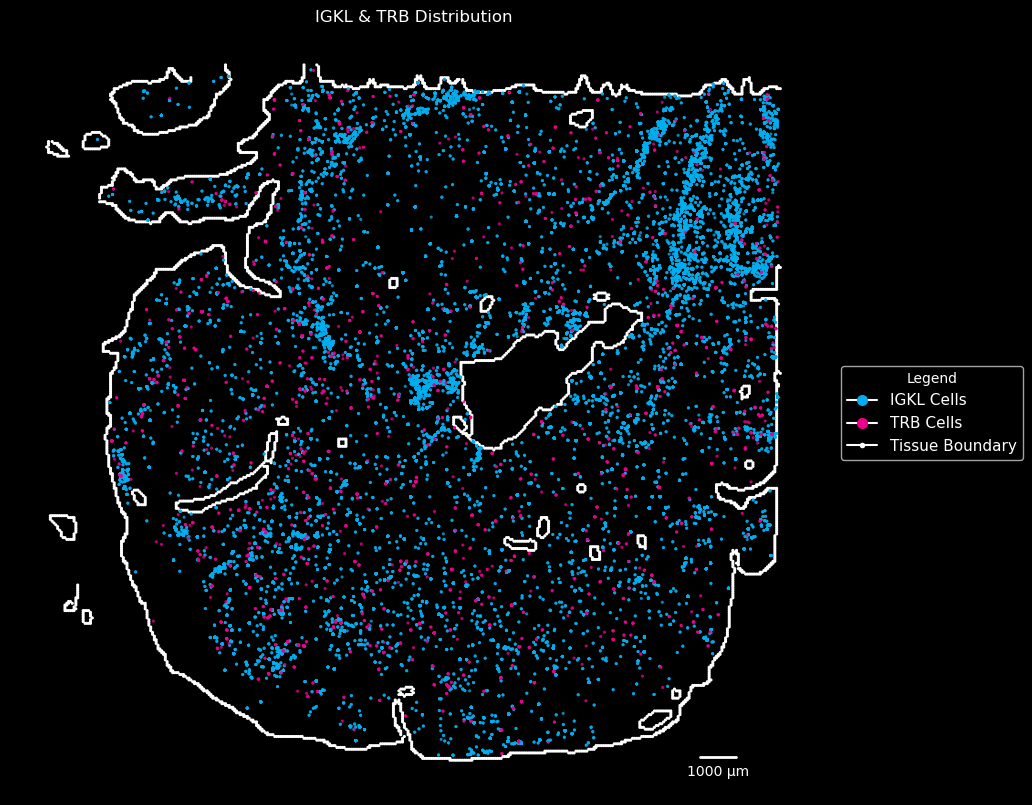

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib.lines import Line2D

# Create a new figure, wide to make space for legend
plt.figure(figsize=(12, 10))
sns.set_theme(rc={'axes.facecolor':'black', 'figure.facecolor':'black'})
ax = plt.gca()

title = 'IGKL & TRB Distribution'
igkl_color = "#00aeef"
trb_color = "#ed008c"

# Plot tissue outline (white background)
if 'tissue_outline' in locals() or 'tissue_outline' in globals():
    tissue_outline_df = pd.DataFrame(tissue_outline, columns=['x', 'y'])
    ax.scatter(
        x=tissue_outline_df['x'],
        y=tissue_outline_df['y'],
        s=5,
        c='white',
        edgecolors='none',
        alpha=1.0,
        label='Tissue Boundary'
    )
    if len(tissue_outline_df) > 0:
        x_min = tissue_outline_df['x'].min()
        x_max = tissue_outline_df['x'].max()
        y_min = tissue_outline_df['y'].min()
        y_max = tissue_outline_df['y'].max()
        x_margin = (x_max - x_min) * 0.05
        y_margin = (y_max - y_min) * 0.05
        ax.set_xlim(x_min - x_margin, x_max + x_margin)
        ax.set_ylim(y_min - y_margin, y_max + y_margin)

# Plot IGKL cells
if 'x' in IGKL_meta.columns and 'y' in IGKL_meta.columns:
    ax.scatter(
        x=IGKL_meta['x'],
        y=IGKL_meta['y'],
        s=5,
        c=igkl_color,
        edgecolors='none',
        alpha=0.8,
        label='IGKL Cells'
    )

# Plot TRB cells
if 'x' in TRB_meta.columns and 'y' in TRB_meta.columns:
    ax.scatter(
        x=TRB_meta['x'],
        y=TRB_meta['y'],
        s=5,
        c=trb_color,
        edgecolors='none',
        alpha=0.8,
        label='TRB Cells'
    )

# Clean axes and set up style
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticklabels([])
ax.set_yticklabels([])
for spine in ax.spines.values():
    spine.set_visible(False)
ax.set_title(title, fontsize=12, color='white')
ax.tick_params(axis='both', colors='white')
ax.grid(False)
ax.set_aspect('equal')
plt.subplots_adjust(right=0.85)

# Custom legend on the right
legend_handles = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor=igkl_color, 
           markersize=8, markeredgewidth=0, label='IGKL Cells'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor=trb_color, 
           markersize=8, markeredgewidth=0, label='TRB Cells'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='white', 
           markersize=4, markeredgewidth=0, label='Tissue Boundary')
]
legend = ax.legend(handles=legend_handles,
                   loc='center left',
                   bbox_to_anchor=(1.02, 0.5),
                   frameon=True,
                   fancybox=True,
                   shadow=True,
                   framealpha=0.8,
                   title='Legend',
                   title_fontsize=10)
plt.setp(legend.get_texts(), color='white')
plt.setp(legend.get_title(), color='white')

# Optional: add scale bar
try:
    x_min, x_max = ax.get_xlim()
    y_min, y_max = ax.get_ylim()
    scalebar_length = 1000
    scalebar_x = x_max - scalebar_length - (x_max - x_min) * 0.10
    scalebar_y = y_min + (y_max - y_min) * 0.05
    if scalebar_x < x_min:
        scalebar_x = x_min + (x_max - x_min) * 0.05
    ax.plot([scalebar_x, scalebar_x + scalebar_length], 
            [scalebar_y, scalebar_y], 
            color='white', 
            linewidth=2)
    ax.text(scalebar_x + scalebar_length / 2, 
            scalebar_y - (y_max - y_min) * 0.01, 
            '1000 µm', 
            color='white', 
            ha='center', 
            va='top', 
            fontsize=10)
except Exception:
    pass

plt.tight_layout(rect=[0, 0, 0.85, 1])  # Ensure nothing cropped by the legend/output
plt.show()
plt.close()